In [1]:
# Import all necessary libraries and functions:
!pip install rdkit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import  train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, RocCurveDisplay, recall_score, f1_score, roc_auc_score
from scipy.stats import sem

!pip install tensorflow-addons
from tensorflow_addons.metrics import RSquare

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Function to convert smiles strings into Morgan fingerprints based on RDKit:
from rdkit.Chem import rdFingerprintGenerator

def smiles_to_fp(smiles, radius=2, n_bits=2048):
    """Encode a molecule from a SMILES string into a fingerprint.

    Args:
      smiles (str): SMILES string defining the molecule.
      radius (int): Radius for the fingerprint
      n_bits (int): Length of the fingerprint.

    Returns:
      The fingerprint as numpy array.
    """
    mol = Chem.MolFromSmiles(smiles)
    rdkgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
    return rdkgen.GetFingerprintAsNumPy(mol)

In [3]:
# Dataset is converted into a Pandas Dataframe. The Morgan fingerprints are generated. The fingerprints and pIC50 values are saved in two NumPy arrays.
df = pd.read_csv('allassays_nodupl_nofrag.csv')
df['fingerprint'] = df['Smiles'].apply(smiles_to_fp)
X = np.array(df['fingerprint'].tolist())
y = np.array(df['pIC50'])

In [4]:
# Scramble y values (pIC50) randomly
_, y_shuffled = shuffle(X, y, random_state=52)

# Define empty lists to store the validation results (R2 and loss value) for each individual fold:
r2_scores=[]
loss_scores=[]

# K-fold Cross Validation model evaluation
kfold = KFold(n_splits=3, shuffle=True, random_state = 3)
for k, (train, test) in enumerate(kfold.split(X)):

  #  Define train/validation split for each fold:
  X_train, X_valid, y_train, y_valid = train_test_split(X[train], y_shuffled[train], test_size=0.1, random_state=22)

  # Final neural network architecture with optimized hyperparameters
  model = keras.Sequential([
      layers.Dense(1024, activation="relu"),
      layers.Dense(1024, activation="relu"),
      layers.Dense(1024, activation="relu"),
      layers.Dense(1024, activation="relu"),
      layers.Dense(1024, activation="relu"),
      layers.Dense(1)
  ])

  # Keras callbacks are used to store results of earlier epochs and enable early stopping:
  callbacks = [
      keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True, verbose=1)]

  # Definition of optimizer function:
  optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

  # Model compilation
  model.compile(optimizer= optimizer,
                loss="mse",
                metrics=[RSquare()])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {k} ...')

  # Fit data to model
  history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128,
                    validation_data=(X_valid, y_valid),
                    callbacks = callbacks,
                    shuffle = True)

  # Generate generalization metrics
  scores = model.evaluate(X[test], y_shuffled[test], verbose=0)
  print(f'Score for fold {k}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
  r2_scores.append(scores[1])
  loss_scores.append(scores[0])

mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

# Print results
print("R-squared values for each fold:", r2_scores)
print("Mean R-squared:", mean_r2)
print("Standard deviation", std_r2)

------------------------------------------------------------------------
Training for fold 0 ...
Epoch 1/100
141/141 [==============================] - 5s 10ms/step - loss: 5.7932 - r_square: -3.4757 - val_loss: 1.7598 - val_r_square: -0.3737
Epoch 2/100
141/141 [==============================] - 1s 5ms/step - loss: 1.6438 - r_square: -0.2700 - val_loss: 1.5837 - val_r_square: -0.2363
Epoch 3/100
141/141 [==============================] - 1s 5ms/step - loss: 1.3732 - r_square: -0.0609 - val_loss: 1.5952 - val_r_square: -0.2452
Epoch 4/100
141/141 [==============================] - 1s 5ms/step - loss: 1.1867 - r_square: 0.0832 - val_loss: 1.4955 - val_r_square: -0.1674
Epoch 5/100
141/141 [==============================] - 1s 5ms/step - loss: 1.0184 - r_square: 0.2132 - val_loss: 1.5762 - val_r_square: -0.2304
Epoch 6/100
141/141 [==============================] - 1s 5ms/step - loss: 0.8835 - r_square: 0.3174 - val_loss: 1.6215 - val_r_square: -0.2658
Epoch 7/100
141/141 [==============

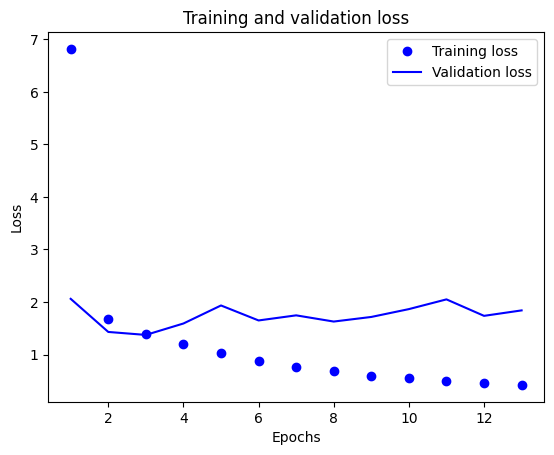

In [5]:
# Plot evolution of training loss (MSE) and training accuracy (R2) for the last fold
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

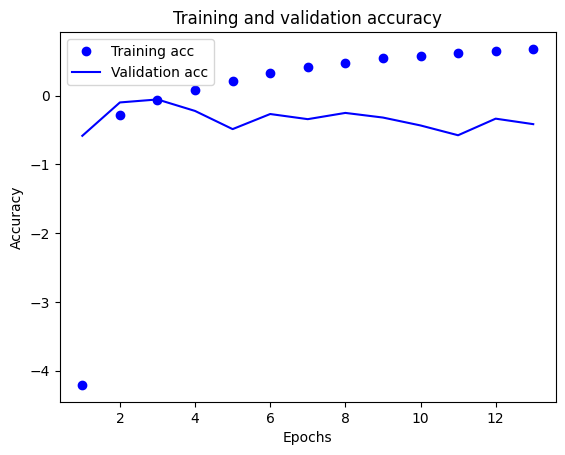

In [6]:
# Plot evolution of test loss (MSE) and test accuracy (R2) for the last fold
plt.clf()
acc = history_dict["r_square"]
val_acc = history_dict["val_r_square"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()